**Examples of Collaborative Filtering based Recommendation Systems**...

reference website: https://blog.csdn.net/Jack_yun_feng/article/details/100176399

The idea of this model based part is to use linear regression method to predict the rating pattern for each user to each product.

Recommende the product with predicted highest rate to user. 

Algorithm is not complex, but it still has a problem. 

The rating of a product can only tell us this item is good but it cannot tell us if the targeting user would buy it or not.

In [16]:
!pip install ipynb

Spliting data...
Data Splited!!!
331553
1
2
3
4
5
6
7
8
9


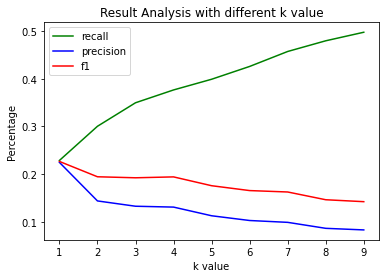

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


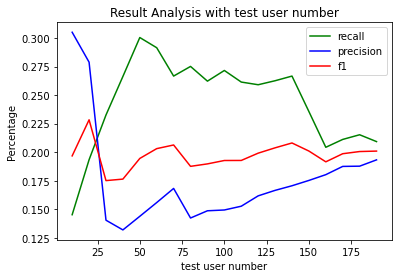

In [17]:
from ipynb.fs.full.user_base import *

In [18]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dataset = pd.read_csv("ratings_Beauty.csv")
dataset_1000 = dataset[:1000]
dataset.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


Step 1: Make a class to encapsulate all the related functions. (To prevent naming conflict from different class functions)

__init__ : includes all the variable initialization and useful parameters.

        number_epochs : number of learning iterations.

        alpha : the learning rate

        reg : the regression rate

        columns : the required column_names from the dataset

fit : further processing parameters

        1) Group dataset based on 'UserId' and 'ProductId', respectively.

        2) Calculate global mean of the 'Rating'.

        3) Initialize bu (user_bias) and bi (item_bias).

        4) Call sgd() to train the model

sgd : Stochastic gradient descent

        Optimizaing bias to increase the accuracy of the prediction.

predict : Predicting equation

        predict_rating = global_mean + user_bias(UserId) + item_bias(ProductId)


In [19]:
class BaselineCFBySGD(object):

    def __init__(self, dataset, number_epochs, alpha, reg, columns=["UserId", "ProductId", "Rating"]):
        self.dataset = dataset
        # 梯度下降最高迭代次数
        self.number_epochs = number_epochs
        # 学习率
        self.alpha = alpha
        # 正则参数
        self.reg = reg
        # 数据集中user-item-rating字段的名称
        self.columns = columns
        # 开始
        self.fit()

    def fit(self):
        '''
        :param dataset: uid, iid, rating
        :return:
        '''
        # 用户评分数据
        self.users_ratings = self.dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        # 物品评分数据
        self.items_ratings = self.dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]
        # 计算全局平均分
        self.global_mean = self.dataset[self.columns[2]].mean()
        # 调用sgd方法训练模型参数
        self.bu, self.bi = self.sgd()

    def sgd(self):
        '''
        利用随机梯度下降，优化bu，bi的值
        :return: bu, bi
        '''
        # 初始化bu、bi的值，全部设为0
        bu = dict(zip(self.users_ratings.index, np.zeros(len(self.users_ratings))))
        bi = dict(zip(self.items_ratings.index, np.zeros(len(self.items_ratings))))

        for i in range(self.number_epochs):
        #   print("iter%d" % i)
            for uid, iid, real_rating, _ in self.dataset.itertuples(index=False):
                error = real_rating - (self.global_mean + bu[uid] + bi[iid])

                bu[uid] += self.alpha * (error - self.reg * bu[uid])
                bi[iid] += self.alpha * (error - self.reg * bi[iid])

        return bu, bi

    def predict(self, uid, iid):
        try:
            predict_rating = self.global_mean + self.bu[uid] + self.bi[iid]
        except Exception as e: 
            # print("Kicked:", e)
            predict_rating = 0
            #predict_rating = 0.0
        return predict_rating


In [20]:
def data_split(dataset, x=0.8):
    '''
    切分数据集
    :param x: 训练集的比例，如x=0.8，则0.2是测试集
    :return: 用户-物品评分矩阵
    '''
    print("Spliting data...")

    trainset = dataset.sample(frac=x)
    trainset_index = trainset.index.tolist()
    testset = dataset.drop(trainset_index)
    #print(trainset.size, "\n", testset.size)
  
    drop_list = []
    for data in np.array(testset):
        if data[0] not in trainset["UserId"]:
            not_predi = testset[testset["UserId"] == data[0]].index
            drop_list.append(not_predi[0])
    testset = testset.drop(drop_list)
    print("Data Splited!!!")

    return trainset, testset

In [223]:
# split the data to trainset and testset
dataCount = 100000
trainset, testset = data_split(dataset[:dataCount], x=0.8)
bcf = BaselineCFBySGD(trainset, 50, 0.034, 0.1, ["UserId", "ProductId", "Rating"])

Spliting data...
Data Splited!!!


In [224]:
trainUserDic, trainItemDic = genUserDic(np.array(dataset[:dataCount]))

In [225]:
def modelRecommendation(bcf, uid, items, k = 10):
    pred_rating_result = [(iid, bcf.predict(uid,iid)) for iid in items]
    # print("pred_rating_result",pred_rating_result)
    pred_rating_result.sort(key = lambda x: x[1], reverse=True)
    # print(pred_rating_result)
    # print(len(pred_rating_result))
    recomList = [iid for iid, mark in pred_rating_result]

    if len(pred_rating_result) < k:
        return recomList, pred_rating_result
    else:
        return recomList[:k], pred_rating_result[:k]

In [226]:
# uids = pd.unique(trainset["UserId"])
# uid = uids[0]
# iids = pd.unique(trainset["ProductId"])

# a,b = modelRecommendation(bcf, uid,iids)

In [227]:
# iids = pd.unique(trainset["ProductId"])
# len(iids)

In [228]:
def recall(testUsers, testUserDic, itemDic, userDic, recomMethod = modelRecommendation, k = 10, bcf = None,trainset=None):
    """计算召回率"""
    hit = 0
    all_ = 0
    count = 0
    for userId in testUsers:
        # count += 1
        # print(count)
        if recomMethod == recommendation:
            recomList, neighbors = recomMethod(userId, userDic, itemDic)
        elif recomMethod == modelRecommendation: 
            recomList, recomListMark = recomMethod(bcf, userId, pd.unique(trainset["ProductId"]),k = k)
        elif recomMethod == hybridRecommendation: recomList, recomListMark = recomMethod(userId, k = k)
        # print("recomList", recomList)
        # print("testUserDic[userId]", testUserDic[userId])
        for tureItem, mark in testUserDic[userId]:
            if tureItem in recomList:
                hit += 1
        all_ += len(testUserDic[userId])
    return hit / (all_ * 1.)

def precision(testUsers, testUserDic, itemDic, userDic, recomMethod = modelRecommendation, k = 10, bcf = None,trainset=None):
    """计算准确率"""
    hit = 0
    all_ = 0
    
    for userId in testUsers:
        recomList, recomListMark = recomMethod(bcf, userId, pd.unique(trainset["ProductId"]),k = k)
        
        for reItem, mark in testUserDic[userId]:
            if reItem in recomList:
                hit += 1
        all_ += len(recomList)
    return hit / (all_ * 1.)

def f1(testUsers, testUserDic, itemDic, userDic, recomMethod = modelRecommendation, k = 10, bcf = None,trainset=None):
    recall_value = recall(testUsers, testUserDic, itemDic, userDic, recomMethod,k=k,bcf=bcf,trainset=trainset)
    precision_value = precision(testUsers, testUserDic, itemDic, userDic, recomMethod,k=k,bcf=bcf,trainset=trainset)
    return 2 * recall_value * precision_value / (precision_value + recall_value)

In [232]:
# Set up the test user id list
# In case, the error cause by the new test user id for the trainning model
listTestUsers = list(set(testset["UserId"]))
print(len(listTestUsers))
users =[]
for userId in listTestUsers:
    if userId in trainUserDic.keys():
        users.append(userId)
lista = users[:]
len(lista)


402


402

In [244]:
recall_list = []
precision_list =[]
f1_list =[]
kv = []
for num in range(1,5001,500):
    print(num)
    kv.append(num)
    recall_value = recall(lista,trainUserDic, trainItemDic, trainUserDic,k=num, bcf =bcf,trainset=trainset)
    recall_list.append(recall_value)
    # print("recall_value",recall_value)

    precision_value = precision(lista,trainUserDic, trainItemDic, trainUserDic,k=num, bcf =bcf,trainset=trainset)
    precision_list.append(precision_value)
    # print(precision_value)

    if (recall_value + precision_value) == 0: f1_value = 0
    else: f1_value = 2 * recall_value * precision_value/(recall_value + precision_value)
    # f1_value = f1(lista,trainUserDic, trainItemDic, trainUserDic,k=num, bcf =bcf,trainset=trainset)
    f1_list.append(f1_value)

1
501
1001
1501
2001
2501
3001
3501
4001
4501


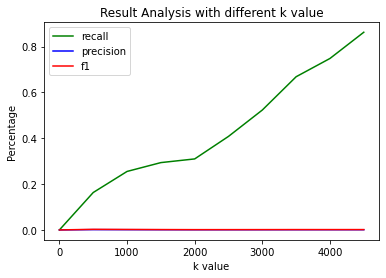

In [245]:
plt.title('Result Analysis with different k value')

plt.plot(kv, recall_list, color='green', label='recall')
plt.plot(kv, precision_list, color='blue', label='precision')
plt.plot(kv, f1_list,  color='red', label='f1')

plt.legend()
plt.xlabel('k value')
plt.ylabel('Percentage')
plt.show()